In [1]:
#check accuracy on the train set
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sgpo.oracle.inference_oracle import inference_oracle
from scipy.stats import spearmanr, pearsonr

import matplotlib as mpl

font = {'family' : 'sans-serif',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

In [19]:
protein = "GB1"
df = pd.read_csv(f"data/{protein}/fitness.csv")
df

,Combo,fitness,n_mut,split
0,MAAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.110345,2,train
1,MACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.257100,2,train
2,MAFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.408461,2,train
3,MAGKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.005356,2,train
4,MAIKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.238196,2,train
...,...,...,...,...
536958,MQYKLILNGKTLKGETTTEAVDGATAEKVFKQYANDNGVDGEWTYD...,0.009231,2,test
536959,MQYKLILNGKTLKGETTTEAVDAAEAEKVFKQYAVDNGVDGEWTYD...,0.003589,2,test
536960,MQYKLILNGKTLWGETTTEAVDAATAEKVFKQYANENGVDGEWTYD...,2.031604,2,test
536961,MQYKLILNGKTLKGETTTEIVDAATAEKVFKQYANDNCVDGEWTYD...,0.119684,2,test


In [3]:
df[df["split"] == "test"]

,Combo,fitness,n_mut,split
440498,MQYKLILNGKTLKGETTTEAVDAATAEKVFDQYANDNGVDGEWTYD...,0.000000,2,test
440499,MQYKLILNGKTLKGETTTEWVDAATAEKVFKQYANDNGVDGEWTYD...,0.176756,2,test
440500,MQYKLILNGKTLKGETTTEAVDAATAPKVFKQYANDNGVDGEWTYD...,0.004366,2,test
440501,MQYKLILNIKTLKGETTTEAVDAATAEKVPKQYANDNGVDGEWTYD...,0.009917,2,test
440502,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVTWEWTYD...,0.003411,2,test
...,...,...,...,...
536958,MQYKLILNGKTLKGETTTEAVDGATAEKVFKQYANDNGVDGEWTYD...,0.009231,2,test
536959,MQYKLILNGKTLKGETTTEAVDAAEAEKVFKQYAVDNGVDGEWTYD...,0.003589,2,test
536960,MQYKLILNGKTLWGETTTEAVDAATAEKVFKQYANENGVDGEWTYD...,2.031604,2,test
536961,MQYKLILNGKTLKGETTTEIVDAATAEKVFKQYANDNCVDGEWTYD...,0.119684,2,test


In [21]:
results_df = pd.DataFrame(columns=["split", "y_true", "y_pred"])
#subsample only 10% of everything in the train split from results_df
train_df = df[df["split"] == "train"].sample(frac=0.1, random_state=42)
other_df = df[df["split"] != "train"]
df = pd.concat((train_df, other_df))

for split in ["train", "validation", "test"]: #"train",
    data = df[df["split"] == split]
    
    if split == "train":
        seqs = data["Combo"].values.tolist()
        loss, y_pred = inference_oracle(seqs, protein, model_path=f"oracle/checkpoints/{protein}")
    else:
        loss, y_pred = inference_oracle(split, protein, model_path=f"oracle/checkpoints/{protein}")
    
    y_true = data["fitness"].values
    results_df = pd.concat((results_df, pd.DataFrame({"split": split, "y_true": y_true, "y_pred": y_pred})))
    corr, _ = spearmanr(y_true, y_pred)
    print(f"{split} spearman correlation: {corr}")
    corr, _ = pearsonr(y_true, y_pred)
    print(f"{split} pearson correlation: {corr}")

/disk1/jyang4/repos/SGPO/oracle/inference_oracle.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss = criterion(torch.tensor(predictions), test_dataset.y)
/tmp/ipykernel_1761958/3958260765.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat((results_df, pd.DataFrame({"split": split, "y_true": y_true, "y_pred": y_pred})))


train spearman correlation: 0.8435328854303781
train pearson correlation: 0.893921952550664


/disk1/jyang4/repos/SGPO/oracle/inference_oracle.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss = criterion(torch.tensor(predictions), test_dataset.y)
/disk1/jyang4/miniconda3/envs/diffusion-guidance/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([53592, 1])) that is different to the input size (torch.Size([53592])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


validation spearman correlation: 0.8429173931693164
validation pearson correlation: 0.8918612750822303


/disk1/jyang4/repos/SGPO/oracle/inference_oracle.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_loss = criterion(torch.tensor(predictions), test_dataset.y)
/disk1/jyang4/miniconda3/envs/diffusion-guidance/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([96465, 1])) that is different to the input size (torch.Size([96465])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


test spearman correlation: 0.8440575122766985
test pearson correlation: 0.8917566877407181


In [20]:
df[df["split"] == "train"].sample(frac=0.1, random_state=42)

,Combo,fitness,n_mut,split
142974,MQYKLILNGKTLKGETTTEAVEAATAEKVFKQYANDNGVDGEWTYD...,0.000000,2,train
110963,MQYKLILNGKTLKGETTTSAVDAATAEKVFIQYANDNGVDGEWTYD...,0.004132,2,train
341784,MQYKLILNGKTLKGETTTEAVDAATAEKVHKQYANDNGVDGEWTYD...,0.784278,2,train
233370,MQYKLILNGKTLNGETTTEAVDAATAEKVFKQYLNDNGVDGEWTYD...,0.050302,2,train
300424,MQYKLILNGKPLKGETTTEAVDAATAEKVFKQYANDNGVDGRWTYD...,0.388011,2,train
...,...,...,...,...
124895,MQYKLILNGKTLKGETTTEHVDAATAEKVFKQYANDCGVDGEWTYD...,0.153473,2,train
162769,MQYKLILNGKTLKGETTTEAKDAPTAEKVFKQYANDNGVDGEWTYD...,2.968127,2,train
112307,MQYKLILNGKTLKGETTTWAVDAATAEKVFKQYANDNSVDGEWTYD...,0.925560,2,train
81357,MQYKLILNGKTLKKETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,0.098531,2,train


In [22]:
corr, _ = pearsonr(y_true, y_pred)
print(f"{split} pearson correlation: {corr}")

test pearson correlation: 0.8917566877407181


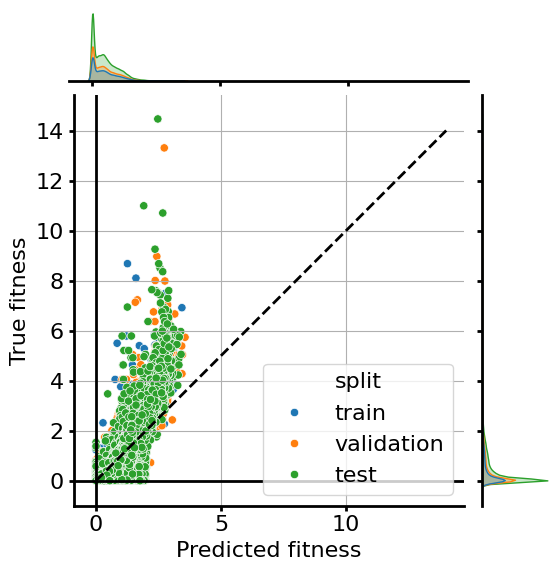

In [26]:
plt.figure_size = (7, 7)
sns.jointplot(data=results_df, x="y_pred", y="y_true", hue="split", legend=True)

#set axes to be proportional
if protein == "TrpB":
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 2.5)
    plt.plot([0, 2.5], [0, 2.5], ls="--", c="black")
elif protein == "CreiLOV":
    plt.xlim(2.25, 4.5)
    plt.ylim(2.25, 4.5)
    plt.plot([0, 4.5], [0, 4.5], ls="--", c="black")
else:
    plt.plot([0, 14], [0, 14], ls="--", c="black")
    
    #add x-axis at 0
plt.axvline(0, color="black", ls="-")
plt.axhline(0, color="black", ls="-")
plt.gca().set_aspect("equal")
plt.ylabel("True fitness")
plt.xlabel("Predicted fitness")
plt.grid()
plt.savefig(f"figures/{protein}_oracle_accuracy.png", dpi=500)